In [28]:
"""
Read this before Running anything


make sure tensorflow, opencv, numpy, Flask, shapely and mathplot lib is all installed

Run the first 2 cells and then Run the Cell which says FLASK CODE

in this folder store model which is the model for CNN prediciton
In this folder store a folder called yolo-coco and inside that folder store 'coco.names', 'yolov3.cfg'and yolov3.weights


Rename car_chase_01.mp4 to demo.mp4

finally, go to 'localhost:5000'


to display the video.

"""

"\nRead this before Running anything\n\n\nmake sure tensorflow, opencv, numpy, Flask, shapely and mathplot lib is all installed\n\nRun the first 2 cells and then Run the Cell which says FLASK CODE\n\nin this folder store model which is the model for CNN prediciton\nIn this folder store a folder called yolo-coco and inside that folder store 'coco.names', 'yolov3.cfg'and yolov3.weights\n\n\nRename car_chase_01.mp4 to demo.mp4\n\nfinally, go to 'localhost:5000'\n\n\nto display the video.\n\n"

In [47]:
import tensorflow as tf
import numpy as np
import os
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy
from tensorflow.python.keras.backend import set_session




sess = tf.Session()
graph = tf.get_default_graph()
set_session(sess)
model = tf.keras.models.load_model('model')


def prepare(filepath):
    global accident_value
    IMG_SIZE = 200
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    
    with graph.as_default():
        set_session(sess)
        x = (model.predict(new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)))
        if x==1:
            accident_value = "accident"
            cv2.imwrite( "static/Final_image.jpg",new_array)
            cv2.imwrite( "images/final_image/image.jpg",new_array)
            plt.imshow(new_array, cmap='gray')
            plt.show()
        return (model.predict(new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)))



In [48]:
""" Run the below cells for every Run! """

' Run the below cells for every Run! '

In [49]:
import time
import threading
path = ""
try:
    from greenlet import getcurrent as get_ident
except ImportError:
    try:
        from thread import get_ident
    except ImportError:
        from _thread import get_ident


class CameraEvent(object):
    """An Event-like class that signals all active clients when a new frame is
    available.
    """
    def __init__(self):
        self.events = {}

    def wait(self):
        """Invoked from each client's thread to wait for the next frame."""
        ident = get_ident()
        if ident not in self.events:
            # this is a new client
            # add an entry for it in the self.events dict
            # each entry has two elements, a threading.Event() and a timestamp
            self.events[ident] = [threading.Event(), time.time()]
        return self.events[ident][0].wait()

    def set(self):
        """Invoked by the camera thread when a new frame is available."""
        now = time.time()
        remove = None
        for ident, event in self.events.items():
            if not event[0].isSet():
                # if this client's event is not set, then set it
                # also update the last set timestamp to now
                event[0].set()
                event[1] = now
            else:
                # if the client's event is already set, it means the client
                # did not process a previous frame
                # if the event stays set for more than 5 seconds, then assume
                # the client is gone and remove it
                if now - event[1] > 5:
                    remove = ident
        if remove:
            del self.events[remove]

    def clear(self):
        """Invoked from each client's thread after a frame was processed."""
        self.events[get_ident()][0].clear()


class BaseCamera(object):
    thread = None  # background thread that reads frames from camera
    frame = None  # current frame is stored here by background thread
    last_access = 0  # time of last client access to the camera
    event = CameraEvent()

    def __init__(self):
        """Start the background camera thread if it isn't running yet."""
        if BaseCamera.thread is None:
            BaseCamera.last_access = time.time()

            # start background frame thread
            BaseCamera.thread = threading.Thread(target=self._thread)
            BaseCamera.thread.start()

            # wait until frames are available
            while self.get_frame() is None:
                time.sleep(0)

    def get_frame(self):
        """Return the current camera frame."""
        BaseCamera.last_access = time.time()

        # wait for a signal from the camera thread
        BaseCamera.event.wait()
        BaseCamera.event.clear()

        return BaseCamera.frame

    @staticmethod
    def frames():
        """"Generator that returns frames from the camera."""
        raise RuntimeError('Must be implemented by subclasses.')

    @classmethod
    def _thread(cls):
        """Camera background thread."""
        print('Starting camera thread.')
        frames_iterator = cls.frames()
        for frame in frames_iterator:
            BaseCamera.frame = frame
            BaseCamera.event.set()  # send signal to clients
            time.sleep(0)

            # if there hasn't been any clients asking for frames in
            # the last 10 seconds then stop the thread
            if time.time() - BaseCamera.last_access > 10:
                frames_iterator.close()
                print('Stopping camera thread due to inactivity.')
                break
        BaseCamera.thread = None
        
import os
import cv2
# from base_camera import BaseCamera


class Camera(BaseCamera):
    video_source = 0

    def __init__(self):
        if os.environ.get('OPENCV_CAMERA_SOURCE'):
            Camera.set_video_source(int(os.environ['OPENCV_CAMERA_SOURCE']))
        super(Camera, self).__init__()

    @staticmethod
    def set_video_source(source):
        Camera.video_source = source

    @staticmethod
    def frames():
        i = 0
        j = 0
        camera = cv2.VideoCapture(path)
        if not camera.isOpened():
            raise RuntimeError('Could not start camera.')

        while True:
            # read current frame
            _, img = camera.read()
            img = cv2.resize(img,(400,300))
            if i%20 == 0:
                j=j+1
#                 s = "acc/ss{}.jpg".format(j) for testing it is this, else it overwrites the same image
                s = "images/image_to_check.jpg"
                cv2.imwrite(s,img)
                obj(s)
                crops(s)
                global x_y_values
                x_y_values = []
            i=i+1
            yield cv2.imencode('.jpg', img)[1].tobytes()
            # encode as a jpeg image and return it
            
x_y_values = []
padding =150
frames = 20
def obj(name):
    value = name
    #value = "object_detection/ss{}.jpg".format(j)
    
    # load the COCO class labels our YOLO model was trained on
    labelsPath = os.path.sep.join(['yolo-coco', "coco.names"])
    LABELS = open(labelsPath).read().strip().split("\n")

    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
        dtype="uint8")

    # derive the paths to the YOLO weights and model configuration
    weightsPath = os.path.sep.join(['yolo-coco', "yolov3.weights"])
    configPath = os.path.sep.join(['yolo-coco', "yolov3.cfg"])

    # load our YOLO object detector trained on COCO dataset (80 classes)
    print("[INFO] loading YOLO from disk...")
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

    # load our input image and grab its spatial dimensions
    image = cv2.imread(value)
    (H, W) = image.shape[:2]

    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()

    # show timing information on YOLO
    print("[INFO] YOLO took {:.6f} seconds".format(end - start))

    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > 0.5:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5,
        0.3)
   
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            temp = []
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = [int(c) for c in COLORS[classIDs[i]]]
            

            
#             text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            text = "{}".format(LABELS[classIDs[i]])
#             print(text)
            if text == "car" or text=="truck":
                temp.append([x,y+h])
                temp.append([x+w,y+h])
                temp.append([x+w,y])
                temp.append([x,y])
#                 temp.append([i])
                x_y_values.append(temp)
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                #cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                cv2.putText(image, str(i)+", "+str(x)+" "+(str(y)), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)

    # show the output image
    #cv2.imshow("Image", image)
    cv2.imwrite("images/image_after_yolo/img.jpg",image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
def crops(value):
    for i in range(len(x_y_values)):
        for j in range (i+1,len(x_y_values)-1):
            box1 = x_y_values[i]
            box2 = x_y_values[j]
            overlap(box1,box2,value)
    
def overlap(box1, box2,value):
    poly_1 = Polygon(box1)
    poly_2 = Polygon(box2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
#     print("overlap", iou*100)
    if iou > 0.02:
        crop(box1,box2, value)
    
def crop(box1, box2, value):

    b1x = box1[1][0] + box1[3][0]
    b1x = b1x/2
    
    b1y = box1[1][1] + box1[3][1]
    b1y = b1y/2
    
    b2x = box2[1][0] + box2[3][0]
    b2x = b2x/2
    
    b2y = box2[1][1] + box2[3][1]
    b2y = b2y/2
    
    c1 = (b1x+b2x)/2 
    c2 = (b1y+b2y)/2 
    img = cv2.imread(value)
    a = c2-padding
    b = c2+padding
    c = c1-padding
    d = c1+padding

    if a < 0:
        a=0
    if b < 0:
        b=0
    if c < 0:
        c=0
    if d < 0:
        d=0
    crop_img = img[int(a):int(b),int(c):int(d)]
    cv2.imwrite( "images/cropped_image/cropped.jpg",crop_img)
    prediction = prepare('images/cropped_image/cropped.jpg')
    if prediction == 1:
        cv2.imwrite( "static/Final_image.jpg",crop_img)
        
    
        


demo.mp4
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
I0213 00:42:43.629019 14744 _internal.py:88]  * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [13/Feb/2020 00:42:46] "GET / HTTP/1.1" 200 -
I0213 00:42:46.072214  3176 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:46] "GET / HTTP/1.1" 200 -


check


127.0.0.1 - - [13/Feb/2020 00:42:46] "GET /static/Final_image.jpg HTTP/1.1" 200 -
I0213 00:42:46.440229 10892 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:46] "GET /static/Final_image.jpg HTTP/1.1" 200 -


Starting camera thread.
[INFO] loading YOLO from disk...


127.0.0.1 - - [13/Feb/2020 00:42:47] "GET /acc HTTP/1.1" 200 -
I0213 00:42:47.588157 16120 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:47] "GET /acc HTTP/1.1" 200 -


[INFO] YOLO took 1.034235 seconds


127.0.0.1 - - [13/Feb/2020 00:42:48] "GET /video_feed HTTP/1.1" 200 -
I0213 00:42:48.619398  6088 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:48] "GET /video_feed HTTP/1.1" 200 -
127.0.0.1 - - [13/Feb/2020 00:42:48] "GET /acc HTTP/1.1" 200 -
I0213 00:42:48.888675  9032 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:48] "GET /acc HTTP/1.1" 200 -


[INFO] loading YOLO from disk...


127.0.0.1 - - [13/Feb/2020 00:42:49] "GET /acc HTTP/1.1" 200 -
I0213 00:42:49.888916 16680 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:49] "GET /acc HTTP/1.1" 200 -


[INFO] YOLO took 1.022180 seconds


127.0.0.1 - - [13/Feb/2020 00:42:50] "GET /acc HTTP/1.1" 200 -
I0213 00:42:50.889281 11140 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:50] "GET /acc HTTP/1.1" 200 -


[INFO] loading YOLO from disk...


127.0.0.1 - - [13/Feb/2020 00:42:51] "GET /acc HTTP/1.1" 200 -
I0213 00:42:51.893853 14500 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:51] "GET /acc HTTP/1.1" 200 -


[INFO] YOLO took 0.927877 seconds
[INFO] loading YOLO from disk...


127.0.0.1 - - [13/Feb/2020 00:42:52] "GET /acc HTTP/1.1" 200 -
I0213 00:42:52.888087 15016 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:52] "GET /acc HTTP/1.1" 200 -
127.0.0.1 - - [13/Feb/2020 00:42:53] "GET /acc HTTP/1.1" 200 -
I0213 00:42:53.889527 16396 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:53] "GET /acc HTTP/1.1" 200 -


[INFO] YOLO took 0.915136 seconds
[INFO] loading YOLO from disk...


127.0.0.1 - - [13/Feb/2020 00:42:54] "GET /acc HTTP/1.1" 200 -
I0213 00:42:54.893564 17216 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:54] "GET /acc HTTP/1.1" 200 -


[INFO] YOLO took 0.927463 seconds


127.0.0.1 - - [13/Feb/2020 00:42:55] "GET /acc HTTP/1.1" 200 -
I0213 00:42:55.887780 14496 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:55] "GET /acc HTTP/1.1" 200 -


[INFO] loading YOLO from disk...


127.0.0.1 - - [13/Feb/2020 00:42:56] "GET /acc HTTP/1.1" 200 -
I0213 00:42:56.892760  2600 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:56] "GET /acc HTTP/1.1" 200 -


[INFO] YOLO took 0.911484 seconds


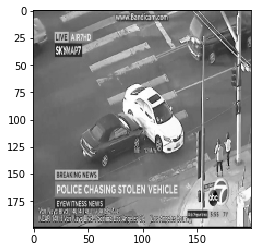

127.0.0.1 - - [13/Feb/2020 00:42:57] "GET /acc HTTP/1.1" 200 -
I0213 00:42:57.889230 16732 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:57] "GET /acc HTTP/1.1" 200 -


[INFO] loading YOLO from disk...


127.0.0.1 - - [13/Feb/2020 00:42:58] "GET /acc HTTP/1.1" 200 -
I0213 00:42:58.897496  9812 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:58] "GET /acc HTTP/1.1" 200 -


[INFO] YOLO took 0.923569 seconds
[INFO] loading YOLO from disk...


127.0.0.1 - - [13/Feb/2020 00:42:59] "GET /acc HTTP/1.1" 200 -
I0213 00:42:59.890202  7080 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:42:59] "GET /acc HTTP/1.1" 200 -
127.0.0.1 - - [13/Feb/2020 00:43:00] "GET /acc HTTP/1.1" 200 -
I0213 00:43:00.927259 15336 _internal.py:88] 127.0.0.1 - - [13/Feb/2020 00:43:00] "GET /acc HTTP/1.1" 200 -


[INFO] YOLO took 0.941344 seconds
[INFO] loading YOLO from disk...


In [50]:
'''
FLASK CODE

'''
path = input()
if path == "demo.mp4":
    padding = 250

count = 0
obje={"accident":"not detected"}
# app.py
# frames = 5 for demo2
# frames = 20 for demo
accident_value = ""
from flask import Flask, render_template, Response, redirect, jsonify
import cv2
import requests
# from camera import Camera
# frame = cv2.videoC

app = Flask(__name__)

app.app_context().push()
#with app.app_context():
        #init_db()
@app.route('/',methods=['GET','POST'])
def index():
    global accident_value
    global obje
    accident_value = "none"
    print('check')
    return render_template('index.html', accident_value = accident_value )

@app.route('/acc',methods=['GET','POST'])
def checks():
    return (jsonify(obje))

def gen(camera):
    global accident_value
    global count
    global obje
    app.app_context().push()

    
    while True:
        #print(accident_value)
        if accident_value == "accident" and count == 0:
           
            count = count + 1
            obje={"accident":"detected"}
            checks()
        
        if count == 50:
            count = 0 
            
        Response(gen(Camera()),
        mimetype='multipart/x-mixed-replace; boundary=frame')
        frame = camera.get_frame()
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')
        

@app.route('/video_feed')
def video_feed():
    accident_value = 'hello'
    return Response(gen(Camera()),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

if __name__ == '__main__':
    app.run(host='0.0.0.0')
    app.app_context().push()